# Simple AR Model ($\tau=4$)

In [10]:
%matplotlib inline
import torch
from torch import nn
import d2l_torch as d2l
import pandas as pd

In [11]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)

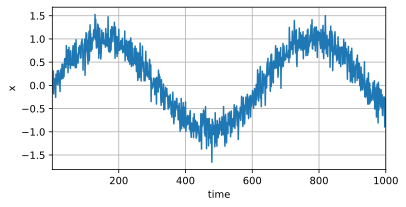

In [12]:
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000], figsize=(6,3))

## Map the data

Label: $y_t = x_t$ and Features: $\textbf{x}_t = [x_{t-\tau},...,x_{t-1}]$

In [17]:
tau = 4
features = torch.zeros((T-tau, tau)) 

In [19]:
for i in range(tau):
    features[:,i] = x[i:T-tau+i] # 뒤에 4개 버림
    # features[:,0] = x[0:1000-4+0] # 뒤에 4개 버림 (996개)
    # ...
    # features[:,3] = x[3:1000-4+3] # 뒤에 4개 버림
labels = x[tau:].reshape((-1,1))

In [28]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train = True)

In [29]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
def get_net():
    net = nn.Sequential(nn.Linear(4,10), nn.ReLU(), nn.Linear(10,1))
    net.apply(init_weights)
    return net

# Square loss
loss = nn.MSELoss()

In [31]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
                f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.073703
epoch 2, loss: 0.058363
epoch 3, loss: 0.054044
epoch 4, loss: 0.051922
epoch 5, loss: 0.049130


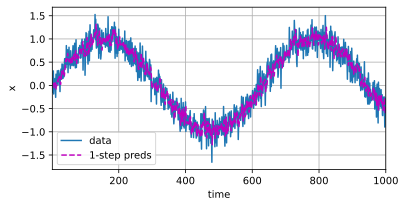

In [33]:
onestep_preds = net(features)
d2l.plot(
[time, time[tau:]],
[x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

In [34]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

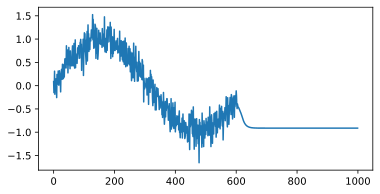

In [37]:
pd.Series(multistep_preds.detach()).plot();

Spectacular Failure. The predictions decay to a constant pretty quickly after a few prediction steps.

왜 why? 에러가 누적 되어 쌓이면서 증폭되기 때문

# Text Preprocessing

In [38]:
import collections
import re

In [39]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
'090b5e7e70c295757f55df93cb0a180b9691891a')


def read_time_machine(): #@save
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## Tokenization

In [46]:
def tokenize(lines, token='word'): #@save
    """Split text lines into word or character tokens."""
    if token == 'word': # 단어 단위
        return [line.split() for line in lines]
    elif token == 'char': # 글자 단위
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [49]:
tokens = tokenize(lines)
# tokens = tokenize(lines, token='char')
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## Vocabulary

*`vocabulary`*: map string token into numerical indices starting from 0

*`corpus`*: count the unique tokens in all the documents from the training set

In [53]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq: # 여기서는 min_freq 0 이니까 모든 단어 다 고려함
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [54]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [55]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [56]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [63]:
import random
import torch

tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

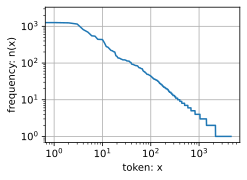

In [64]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

In [66]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [67]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [28, 29, 30, 31, 32]])
X:  tensor([[12, 13, 14, 15, 16],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[22, 23, 24, 25, 26],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[23, 24, 25, 26, 27],
        [18, 19, 20, 21, 22]])


In [68]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [69]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


In [70]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [71]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab